# GIS Practicum: Energy 
## Citing Optimal EV DCFC Locations in North Carolina
#### Abhishek Sanjay Jain, Duke University Nicholas School of the Environment (aj297@duke.edu) 
Code: Compute Nearby Amenities for Each Exit (#7)

Purpose: We fetch the exits data to understand where can these DCFCs be placed along highway corrdiors to minimize range anxiety to support growth of EVs in North Carolina. 

Methodology:
1. Get the exits in the code
2. Buffer 1 mile around the exit to identify amenities
3. Convert into common CRS and then combine into multipolygon, just like we did previously 
4. Identify amenities into buffer zone by query in one object 
5. Quantify total resturants and cafes in the zone. 

In [1]:
#Import packages
import geopandas as gpd
import osmnx as ox
import shapely

#import shapely.speedups
from shapely import speedups

True

In [2]:
#Read in exits feature class as a geodataframe
exits_gdf = gpd.read_file('../Data/MJBA/Exits.shp')

geopandas.geodataframe.GeoDataFrame

In [3]:
#Check the spatial reference of the exit features
print(exits_gdf.crs)

epsg:4326


Why convert into UTM Zone 17N, since WGS 84 is a degree-based CRS, it will not be easy to deal with distances. It specifies coordinates in meters. 

In [4]:
#Transform our data to the projected UTM Zone 17N crs
exits_gdf = exits_gdf.to_crs(32617)

epsg:32617


In [5]:
#Buffer the exits 1 mile (1609.34 m); transform to WGS84, and dissolve into a single shape
exits_gdf['geometry'] = exits_gdf['geometry'].buffer(1609.34)

In [6]:
#Transform the buffered features to WGS 84
exits_gdf_wgs84 = exits_gdf.to_crs(4326)

In [7]:
#Combine features into a single multipolygon
theSearchArea = exits_gdf_wgs84.unary_union

shapely.geometry.multipolygon.MultiPolygon

In [8]:
#Extract restaurants in search area 
theAmenities = ox.pois.create_poi_gdf(polygon=theSearchArea,amenities=['restaurant','cafes'])

In [9]:
#Save the data to a CSV
theAmenities.to_csv('../Data/OSM/Amenities_1mile.csv')

In [10]:
#List the unique types of features
theAmenities['geometry'].type.unique()

array(['Point', 'Polygon', 'MultiPolygon'], dtype=object)

In [11]:
#Parse the dataframe to three, based on geometry type
theAmenities_points = theAmenities.loc[theAmenities['geometry'].type == 'Point'].reset_index()
theAmenities_polys = theAmenities.loc[theAmenities['geometry'].type != 'Point'].reset_index()

In [12]:
#Convert polygon features to points by taking their centroids
theAmenities_polys['geometry'] = theAmenities_polys['geometry'].centroid
theAmenities_polys['geometry'].type.unique()

array(['Point'], dtype=object)

In [13]:
#Append the three together
import pandas as pd
theAmenities_all = pd.concat([theAmenities_points,theAmenities_polys])
theAmenities_all.shape

(1401, 209)

In [14]:
#Save to a shapefile, selecting only the amenity type as an attribute
theAmenities_all[['amenity','geometry']].to_file('../Data/OSM/OSM_amenities.shp')

In [15]:
#Get the area around one exit feature (the 56th one, just to grab one I know has amenities)
theArea = exits_gdf_wgs84.at[56,'geometry']

In [16]:
#Create a mask of amenities within this shape
theSpatialMask = theAmenities_all.within(theArea)

In [17]:
#Count returns the number of "trues" within this mask
theSpatialMask.sum()

2

In [18]:
#Define a function
def get_amenity_count(theShape):
    return theAmenities_all.within(theShape).sum()

In [19]:
#Apply the function to the get
amenity_count = exits_gdf_wgs84['geometry'].apply(get_amenity_count)

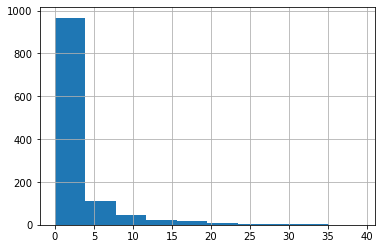

In [20]:
#Plot a histogram of the counts
amenity_count.hist();

In [21]:
#Re-read in the exit features (since we modified them) and attach the amenity count data
exits_gdf = gpd.read_file('../Data/Processed/Exits_distance_to_DCFC.shp')
exits_gdf['amenity_n'] = amenity_count
exits_gdf.head()

,FID,Exit_ID,Longitude,Latitude,County,State,Highway,Type,AADT,Pop_dens,Comm_1mi,Ports_5mi,Ports_10mi,Ports_20mi,Close_nonT,Dist_to_DC,geometry,amenity_n
0,7059,US-64_Cherokee_NC_Exit_1,-84.314304,35.019492,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.094152,103,POINT (197578.012 3880227.389),0
1,7060,US-64_Cherokee_NC_Exit_2,-84.311492,35.014933,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.365230,102,POINT (197817.907 3879713.054),0
2,7061,US-64_Cherokee_NC_Exit_3,-84.295528,35.013561,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,35.233979,102,POINT (199270.172 3879512.464),0
3,7062,US-64_Cherokee_NC_Exit_4,-84.280291,35.012880,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.048303,101,POINT (200658.638 3879391.092),0
4,7063,US-64_Cherokee_NC_Exit_5,-84.275190,35.017816,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.186597,100,POINT (201142.266 3879923.503),0


In [22]:
#Finally, save the exits to a new feature class
exits_gdf.to_file('../Data/Processed/exits_amenities.shp')

In [23]:
#Bonus Part for a quick visual

In [24]:
#Import contextily 
import contextily as ctx

In [25]:
#Transform to web mercator (to match contextily base maps)
exits_gdf_wm = exits_gdf.to_crs(3857)

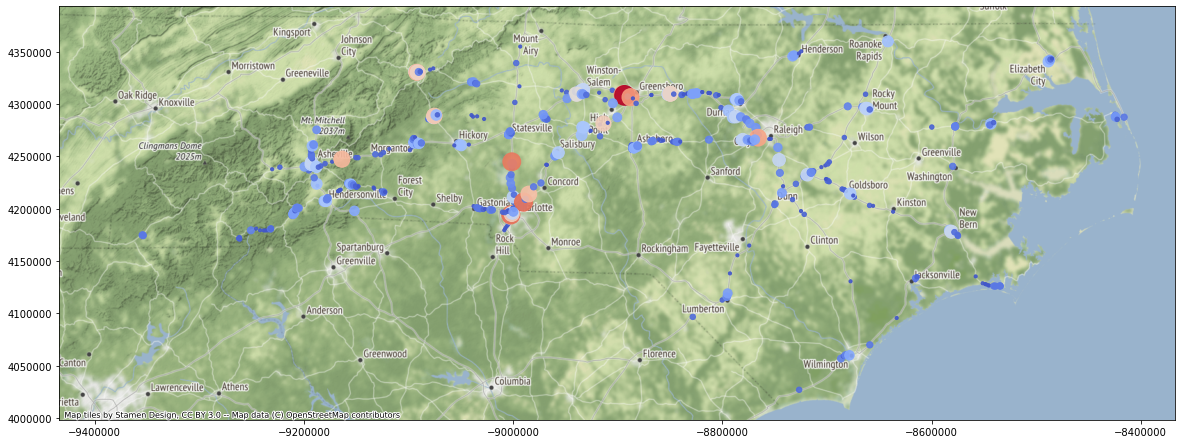

In [26]:
#Plot the amenities to an axis called 'ax'
ax =exits_gdf_wm.plot('amenity_n',
                      cmap='coolwarm',
                      markersize= exits_gdf['amenity_n']*10,
                      alpha=0.9,
                      figsize=(20,10));
# Add basemap
ctx.add_basemap(ax)